# Collaborative Filtering on Google Analytics Data


### Learning objectives
1. Prepare the user-item matrix and use it with WALS.
2. Train a `WALSMatrixFactorization` within TensorFlow locally and on AI Platform.
3. Visualize the embedding vectors with principal components analysis.


## Overview
This notebook demonstrates how to implement a WALS matrix refactorization approach to do collaborative filtering.

Each learning objective will correspond to a __#TODO__ in the notebook, where you will complete the notebook cell's code before running the cell. Refer to the [solution notebook](../solutions/wals.ipynb) for reference.


In [1]:
import os
PROJECT = "cloud-training-demos" # REPLACE WITH YOUR PROJECT ID
BUCKET = "cloud-training-demos-ml" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "1.15"

In [2]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [3]:
import tensorflow as tf
print(tf.__version__)

1.15.5


## Create raw dataset
<p>
For collaborative filtering, you don't need to know anything about either the users or the content. Essentially, all you need to know is userId, itemId, and rating that the particular user gave the particular item.
<p>
In this case, you are working with newspaper articles. The company doesn't ask their users to rate the articles. However, you can use the time-spent on the page as a proxy for rating.
<p>
Normally, you would also add a time filter to this ("latest 7 days"), but your dataset is itself limited to a few days.

In [4]:
from google.cloud import bigquery
bq = bigquery.Client(project = PROJECT)

sql = """
WITH CTE_visitor_page_content AS (
    SELECT
        # Schema: https://support.google.com/analytics/answer/3437719?hl=en
        # For a completely unique visit-session ID, you combine combination of fullVisitorId and visitNumber:
        CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS visitorId,
        (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
        (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
    FROM
        `cloud-training-demos.GA360_test.ga_sessions_sample`,   
        UNNEST(hits) AS hits
    WHERE 
        # only include hits on pages
        hits.type = "PAGE"
GROUP BY   
        fullVisitorId,
        visitNumber,
        latestContentId,
        hits.time )
-- Aggregate web stats
SELECT   
    visitorId,
    latestContentId as contentId,
    SUM(session_duration) AS session_duration
FROM
    CTE_visitor_page_content
WHERE
    latestContentId IS NOT NULL 
GROUP BY
    visitorId, 
    latestContentId
HAVING 
    session_duration > 0
"""

df = bq.query(sql).to_dataframe()
df.head()

,visitorId,contentId,session_duration
0,1012012094517511217-1,299949290,218676
1,1614877438160481626-349,29455408,438692
2,1815317450115839569-235,299807267,160669
3,1950053456137072413-10,243386345,102636
4,2179122255490468209-180,299925086,6041


In [5]:
stats = df.describe()
stats

,session_duration
count,2.843430e+05
mean,1.247665e+05
std,2.311307e+05
min,1.000000e+00
25%,1.605050e+04
50%,5.624600e+04
75%,1.271425e+05
max,7.690598e+06


<AxesSubplot:ylabel='Frequency'>

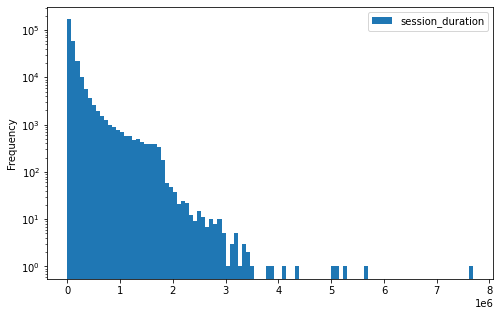

In [6]:
df[["session_duration"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

<AxesSubplot:ylabel='Frequency'>

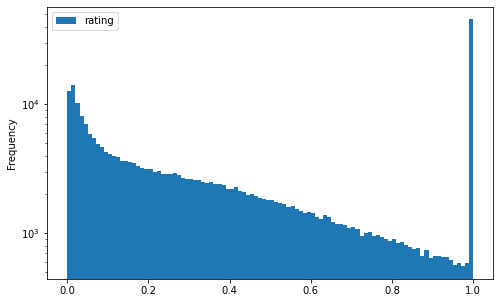

In [7]:
# The rating is the session_duration scaled to be in the range 0-1.  This will help with training.
median = stats.loc["50%", "session_duration"]
df["rating"] = 0.3 * df["session_duration"] / median
df.loc[df["rating"] > 1, "rating"] = 1
df[["rating"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

In [8]:
del df["session_duration"]

In [9]:
%%bash
rm -rf data
mkdir data

In [10]:
# Write object to a comma-separated values (csv) file.
# TODO 1: Your code here

In [11]:
!head data/collab_raw.csv

1012012094517511217-1,299949290,1.0
1614877438160481626-349,29455408,1.0
1815317450115839569-235,299807267,0.8569622728727375
1950053456137072413-10,243386345,0.5474309284215766
2179122255490468209-180,299925086,0.03222095793478647
2477455524323251766-1,299936493,0.3514756604914127
277149937495438413-384,299777707,0.1444742737261316
2912361176772133138-147,299796840,1.0
3868650583032521586-577,299814183,0.5796732212068414
4086929260756256102-380,299946732,1.0


## Create dataset for WALS
<p>
The raw dataset (above) won't work for WALS:
<ol>
<li> The userId and itemId have to be 0,1,2 ... so you need to create a mapping from visitorId (in the raw data) to userId and contentId (in the raw data) to itemId.
<li> You will need to save the above mapping to a file because at prediction time, you'll need to know how to map the contentId in the table above to the itemId.
<li> You'll need two files: a "rows" dataset where all the items for a particular user are listed; and a "columns" dataset where all the users for a particular item are listed.
</ol>

<p>

### Mapping

In [12]:
import pandas as pd
import numpy as np
def create_mapping(values, filename):
    with open(filename, 'w') as ofp:
        value_to_id = {value:idx for idx, value in enumerate(values.unique())}
        for value, idx in value_to_id.items():
            ofp.write("{},{}\n".format(value, idx))
    return value_to_id

df = pd.read_csv(filepath_or_buffer = "data/collab_raw.csv",
                 header = None,
                 names = ["visitorId", "contentId", "rating"],
                dtype = {"visitorId": str, "contentId": str, "rating": np.float})
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)
user_mapping = create_mapping(df["visitorId"], "data/users.csv")
item_mapping = create_mapping(df["contentId"], "data/items.csv")

In [13]:
!head -3 data/*.csv

==> data/collab_raw.csv <==
1012012094517511217-1,299949290,1.0
1614877438160481626-349,29455408,1.0
1815317450115839569-235,299807267,0.8569622728727375

==> data/items.csv <==
299949290,0
29455408,1
299807267,2

==> data/users.csv <==
1012012094517511217-1,0
1614877438160481626-349,1
1815317450115839569-235,2


In [14]:
df["userId"] = df["visitorId"].map(user_mapping.get)
df["itemId"] = df["contentId"].map(item_mapping.get)

In [15]:
mapped_df = df[["userId", "itemId", "rating"]]
mapped_df.to_csv(path_or_buf = "data/collab_mapped.csv", index = False, header = False)
mapped_df.head()

,userId,itemId,rating
0,0,0,1.000000
1,1,1,1.000000
2,2,2,0.856962
3,3,3,0.547431
4,4,4,0.032221


### Creating rows and columns datasets

In [16]:
import pandas as pd
import numpy as np
mapped_df = pd.read_csv(filepath_or_buffer = "data/collab_mapped.csv", header = None, names = ["userId", "itemId", "rating"])
mapped_df.head()

,userId,itemId,rating
0,0,0,1.000000
1,1,1,1.000000
2,2,2,0.856962
3,3,3,0.547431
4,4,4,0.032221


In [17]:
NITEMS = np.max(mapped_df["itemId"]) + 1
NUSERS = np.max(mapped_df["userId"]) + 1
mapped_df["rating"] = np.round(mapped_df["rating"].values, 2)
print("{} items, {} users, {} interactions".format( NITEMS, NUSERS, len(mapped_df) ))

5662 items, 120983 users, 284343 interactions


In [18]:
grouped_by_items = mapped_df.groupby("itemId")
iter = 0
for item, grouped in grouped_by_items:
    print(item, grouped["userId"].values, grouped["rating"].values)
    iter = iter + 1
    if iter > 5:
        break

0 [    0   357   561   608   746  1119  1159  1207  1315  1348  1370  1396
  1940  2035  2143  2254  3169  3313   176  3692   611  4003  4528  1432
  4625  4862  4879  5110  5324  5409  5506  5693  5732  5743  5838   491
  7167  7349  7908  7919  8064  8217  5758  8764  8829  9050  9140  9311
  9417  9820 10368 10418 10809 10822 10911 11351 11761  9110 11982  3345
 12292 12599 12841 12863 13342 13758 13986 14038 14153 14357 15069 15074
 15106 15346 15424 15519 13030 16265 16363  5322 16416 16560 16749 17042
 17077 17403 17442  6664 17575 17674 17735 17916 17990 18152 18181 13354
 18383 18532 16206 13652 18643 18905 11473 19213 19655 19685 19699 17437
 19817  3948 20195 15545 20285 20733 20792 16549 21222  5923 21627 21796
 12084 14759 22053 22116 22691  1287 22717 20511 23252 23446 23479  5683
 23796 17283 24177 24348   810 10004 24800 25200 13567  1899  8200 25455
 25570 25629 25806 25822 25870 25904 11926 26330 26598 26610 26751 26914
 27307 28187  6666   579 28556 28604 28708 28731 

In [19]:
import tensorflow as tf
grouped_by_items = mapped_df.groupby("itemId")
with tf.python_io.TFRecordWriter("data/users_for_item") as ofp:
    for item, grouped in grouped_by_items:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [item])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["userId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [20]:
grouped_by_users = mapped_df.groupby("userId")
with tf.python_io.TFRecordWriter("data/items_for_user") as ofp:
    for user, grouped in grouped_by_users:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [user])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["itemId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [21]:
!ls -lrt data

total 36580
-rw-r--r-- 1 jupyter jupyter 14124035 May 16 17:32 collab_raw.csv
-rw-r--r-- 1 jupyter jupyter  3529114 May 16 17:32 users.csv
-rw-r--r-- 1 jupyter jupyter    82083 May 16 17:32 items.csv
-rw-r--r-- 1 jupyter jupyter  7667828 May 16 17:32 collab_mapped.csv
-rw-r--r-- 1 jupyter jupyter  2296476 May 16 17:33 users_for_item
-rw-r--r-- 1 jupyter jupyter  9743438 May 16 17:33 items_for_user


To summarize, you created the following data files from collab_raw.csv:
<ol>
<li> ```collab_mapped.csv``` is essentially the same data as in ```collab_raw.csv``` except that ```visitorId``` and ```contentId``` which are business-specific have been mapped to ```userId``` and ```itemId``` which are enumerated in 0,1,2,....  The mappings themselves are stored in ```items.csv``` and ```users.csv``` so that they can be used during inference.
<li> ```users_for_item``` contains all the users/ratings for each item in TFExample format
<li> ```items_for_user``` contains all the items/ratings for each user in TFExample format
</ol>

## Train with WALS

Once you have the dataset, do matrix factorization with WALS using the [WALSMatrixFactorization](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) in the contrib directory.
This is an estimator model, so it should be relatively familiar.
<p>
As usual, you write an input_fn to provide the data to the model, and then create the Estimator to do train_and_evaluate.
Because it is in contrib and hasn't moved over to tf.estimator yet, you use tf.contrib.learn.Experiment to handle the training loop.<p>
Make sure to replace <strong># TODO</strong> in below code.

In [22]:
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
  
def read_dataset(mode, args):
    def decode_example(protos, vocab_size):
        # TODO 2: Your code here
        return
  
  
    def remap_keys(sparse_tensor):
        # Current indices of your SparseTensor that you need to fix
        bad_indices = sparse_tensor.indices # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)
        # Current values of your SparseTensor that you need to fix
        bad_values = sparse_tensor.values # shape = (current_batch_size * (number_of_items/users[i] + 1),)

        # Since batch is ordered, the last value for a batch index is the user
        # Find where the batch index chages to extract the user rows
        # 1 where user, else 0
        user_mask = tf.concat(values = [bad_indices[1:,0] - bad_indices[:-1,0], tf.constant(value = [1], dtype = tf.int64)], axis = 0) # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)

        # Mask out the user rows from the values
        good_values = tf.boolean_mask(tensor = bad_values, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        item_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        user_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 1))[:, 1] # shape = (current_batch_size,)

        good_user_indices = tf.gather(params = user_indices, indices = item_indices[:,0]) # shape = (current_batch_size * number_of_items/users[i],)

        # User and item indices are rank 1, need to make rank 1 to concat
        good_user_indices_expanded = tf.expand_dims(input = good_user_indices, axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_item_indices_expanded = tf.expand_dims(input = item_indices[:, 1], axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_indices = tf.concat(values = [good_user_indices_expanded, good_item_indices_expanded], axis = 1) # shape = (current_batch_size * number_of_items/users[i], 2)

        remapped_sparse_tensor = tf.SparseTensor(indices = good_indices, values = good_values, dense_shape = sparse_tensor.dense_shape)
        return remapped_sparse_tensor

    
    def parse_tfrecords(filename, vocab_size):
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        files = tf.gfile.Glob(filename = os.path.join(args["input_path"], filename))

        # Create dataset from file list
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.map(map_func = lambda x: decode_example(x, vocab_size))
        dataset = dataset.repeat(count = num_epochs)
        dataset = dataset.batch(batch_size = args["batch_size"])
        dataset = dataset.map(map_func = lambda x: remap_keys(x))
        return dataset.make_one_shot_iterator().get_next()
  
    def _input_fn():
        features = {
            WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords("items_for_user", args["nitems"]),
            WALSMatrixFactorization.INPUT_COLS: parse_tfrecords("users_for_item", args["nusers"]),
            WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
        }
        return features, None

    return _input_fn

This code is helpful in developing the input function. You don't need it in production.

In [23]:
def try_out():
    with tf.Session() as sess:
        fn = read_dataset(
            mode = tf.estimator.ModeKeys.EVAL, 
            args = {"input_path": "data", "batch_size": 4, "nitems": NITEMS, "nusers": NUSERS})
        feats, _ = fn()
        
        print(feats["input_rows"].eval())
        print(feats["input_rows"].eval())

try_out()

2022-05-16 17:40:20.509438: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200225000 Hz
2022-05-16 17:40:20.510339: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a7e3dcc0d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-16 17:40:20.510379: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-16 17:40:20.511445: I tensorflow/core/common_runtime/process_util.cc:136] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Instructions for updating:
No similar op available at this time.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
SparseTensorValue(indices=array([[   0,    0],
       [   0,  129],
       [   0,  233],
       [   0,  662],
       [   1,    1],
       [   1,    9],
       [   1,   13],
       [   1,   52],
       [   1,  160],
       [   1,  200],
       [   1,  261],
       [   1, 5635],
       [   2,    2],
       [   2,  182],
       [   3,    3],
       [   3,  144],
       [   3, 5611],
       [   3, 5615],
       [   3, 5616],
       [   3, 5620],
       [   3, 5623],
       [   3, 5624],
       [   3, 5637],
       [   3, 5638]]), values=array([1.  , 0.89, 1.  , 1.  , 1.  , 0.07, 0.34, 0.

In [25]:
def find_top_k(user, item_factors, k):
    all_items = tf.matmul(a = tf.expand_dims(input = user, axis = 0), b = tf.transpose(a = item_factors))
    topk = tf.nn.top_k(input = all_items, k = k)
    return tf.cast(x = topk.indices, dtype = tf.int64)
    
def batch_predict(args):
    import numpy as np
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        # This is how you would get the row factors for out-of-vocab user data
        # row_factors = list(estimator.get_projections(input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args)))
        # user_factors = tf.convert_to_tensor(np.array(row_factors))

        # But for in-vocab data, the row factors are already in the checkpoint
        user_factors = tf.convert_to_tensor(value = estimator.get_row_factors()[0]) # (nusers, nembeds)
        # In either case, you have to assume catalog doesn"t change, so col_factors are read in
        item_factors = tf.convert_to_tensor(value = estimator.get_col_factors()[0])# (nitems, nembeds)

        # For each user, find the top K items
        topk = tf.squeeze(input = tf.map_fn(fn = lambda user: find_top_k(user, item_factors, args["topk"]), elems = user_factors, dtype = tf.int64))
        with file_io.FileIO(os.path.join(args["output_dir"], "batch_pred.txt"), mode = 'w') as f:
            for best_items_for_user in topk.eval():
                f.write(",".join(str(x) for x in best_items_for_user) + '\n')

def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args["num_epochs"] * args["nusers"]) / args["batch_size"])
    steps_in_epoch = int(0.5 + args["nusers"] / args["batch_size"])
    print("Will train for {} steps, evaluating once every {} steps".format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                num_rows = args["nusers"], 
                num_cols = args["nitems"],
                embedding_dimension = args["n_embeds"],
                model_dir = args["output_dir"]),
            train_input_fn = read_dataset(tf.estimator.ModeKeys.TRAIN, args),
            eval_input_fn = read_dataset(tf.estimator.ModeKeys.EVAL, args),
            train_steps = train_steps,
            eval_steps = 1,
            min_eval_frequency = steps_in_epoch
        )

    from tensorflow.contrib.learn.python.learn import learn_runner
    learn_runner.run(experiment_fn = experiment_fn, output_dir = args["output_dir"])
    
    batch_predict(args)

In [26]:
import shutil
shutil.rmtree(path = "wals_trained", ignore_errors=True)
train_and_evaluate({
    "output_dir": "wals_trained",
    "input_path": "data/",
    "num_epochs": 0.05,
    "nitems": NITEMS,
    "nusers": NUSERS,

    "batch_size": 512,
    "n_embeds": 10,
    "topk": 3
  })

Will train for 12 steps, evaluating once every 236 steps
Instructions for updating:
Use tf.estimator.train_and_evaluate.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc3e838dfd0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local

In [27]:
!ls wals_trained

batch_pred.txt
checkpoint
eval
events.out.tfevents.1652722839.tensorflow-1-15-20220516-225105
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-12.data-00000-of-00001
model.ckpt-12.index
model.ckpt-12.meta


In [28]:
!head wals_trained/batch_pred.txt

5526,129,885
4712,2402,2620
2710,139,1001
885,5526,3450
202,370,2839
4972,1085,4505
4896,1687,2833
3418,5095,2702
3537,479,4896
1001,4516,2347


## Run as a Python module

Let's run it as Python module for just a few steps.

In [29]:
os.environ["NITEMS"] = str(NITEMS)
os.environ["NUSERS"] = str(NUSERS)

In [30]:
%%bash
rm -rf wals.tar.gz wals_trained
gcloud ai-platform local train \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    -- \
    --output_dir=${PWD}/wals_trained \
    --input_path=${PWD}/data \
    --num_epochs=0.01 --nitems=${NITEMS} --nusers=${NUSERS} \
    --job-dir=./tmp

Will train for 2 steps, evaluating once every 236 steps




Instructions for updating:
Use tf.estimator.train_and_evaluate.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdf7d13df90>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'cloud', '_is_chief': True, '_evaluation_master': '', '_train

## Run on Cloud

In [31]:
%%bash
gsutil -m cp data/* gs://${BUCKET}/wals/data

Copying file://data/collab_mapped.csv [Content-Type=text/csv]...
Copying file://data/collab_raw.csv [Content-Type=text/csv]...                   
Copying file://data/items.csv [Content-Type=text/csv]...                        
Copying file://data/items_for_user [Content-Type=application/octet-stream]...   
Copying file://data/users_for_item [Content-Type=application/octet-stream]...   
Copying file://data/users.csv [Content-Type=text/csv]...                        
- [6/6 files][ 35.7 MiB/ 35.7 MiB] 100% Done                                    
Operation completed over 6 objects/35.7 MiB.                                     


In [32]:
%%bash
OUTDIR=gs://${BUCKET}/wals/model_trained
JOBNAME=wals_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    --runtime-version=$TFVERSION \
    -- \
    --output_dir=$OUTDIR \
    --input_path=gs://${BUCKET}/wals/data \
    --num_epochs=10 --nitems=${NITEMS} --nusers=${NUSERS} 

gs://qwiklabs-gcp-01-7f6e984e70dc/wals/model_trained us-central1 wals_220516_174236
jobId: wals_220516_174236
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [wals_220516_174236] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe wals_220516_174236

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs wals_220516_174236


This will take <b>10 minutes</b> to complete. Rerun the above command until the jobs gets submitted.

## Get row and column factors

Once you have a trained WALS model, you can get row and column factors (user and item embeddings) from the checkpoint file. You'll look at how to use these in the section on building a recommendation system using deep neural networks.

In [33]:
def get_factors(args):
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        row_factors = estimator.get_row_factors()[0]
        col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [34]:
args = {
    "output_dir": "gs://{}/wals/model_trained".format(BUCKET),
    "nitems": NITEMS,
    "nusers": NUSERS,
    "n_embeds": 10
  }

user_embeddings, item_embeddings = get_factors(args)
print(user_embeddings[:3])
print(item_embeddings[:3])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc3e9a79a10>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'gs://qwiklabs-gcp-01-7f6e984e70dc/wals/model_trained', '_session_creation_timeout_secs': 7200}
[[ 3.6948849e-03 -8.5906551e-04  4.8303331e-04 -1.5890118e-03
   3.2951573e-03  1.8742392e-03 -4.0969993e-03

You can visualize the embedding vectors using dimensional reduction techniques such as PCA.

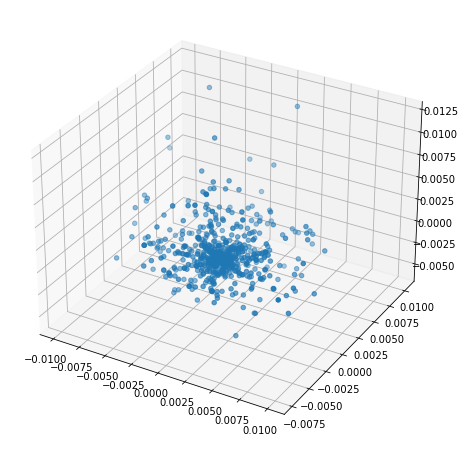

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(user_embeddings)
user_embeddings_pca = # TODO 3: Your code here

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = "3d")
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

<pre>
# Copyright 2022 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>